In [1]:
import pandas as pd
import numpy as np
from bauer.models import LossAversionModel, LossAversionRegressionModel

import pytensor


# RegressionModel

In this notebook we simulate and recover a `LossAversionRegressionModel`. We simulate data where the noise in the representation
of gain and losses is larger when they are presented first.

We model that using an extra data column *losses_first* that indicates that a loss was presented first (when `True`).
Otherwise, the gain was presented first.

In [2]:
# Set up paradigm (note: now we also have a subjet level for each trial)
gains = np.arange(5., 50., 5)
losses = np.arange(5., 50., 5)


paradigm = pd.MultiIndex.from_product([gains, losses], names=['gain', 'loss']).to_frame(index=False)


parameters1 = {'evidence_sd_gains':.5, # Losses first, so relatively smaller
               'evidence_sd_losses':1.0, # Losses first, so relatively larger
               'prior_mu_gains':np.log(25),
               'prior_mu_losses':np.log(25),
               'prior_sd_gains':.5,
               'prior_sd_losses':.5, }

parameters2 = {'evidence_sd_gains':1.,  # Gains first, so relatively larger
               'evidence_sd_losses':0.35, # Gains first, so relatively smaller
               'prior_mu_gains':np.log(25),
               'prior_mu_losses':np.log(25),
               'prior_sd_gains':.5,
               'prior_sd_losses':.5,}


model_ = LossAversionModel(fix_prior_sds=True, paradigm_type='mixed_vs_0')

n_samples = 10
# Simulate as two seperate datasets
data1 = model_.simulate(paradigm, parameters1, n_samples=n_samples)
data2 = model_.simulate(paradigm, parameters2, n_samples=n_samples)

# Concatenate the two datasets
data = pd.concat((data1, data2), keys=[True, False], names=['losses_first']).reset_index('losses_first')

# Some convenience columns
data['choice'] = data['simulated_choice']
data['ev'] = data['gain'] - data['loss']

When we plot the simulated data, we see that whether people are loss averse or 'risk seeking' depends on the order of the trials. 

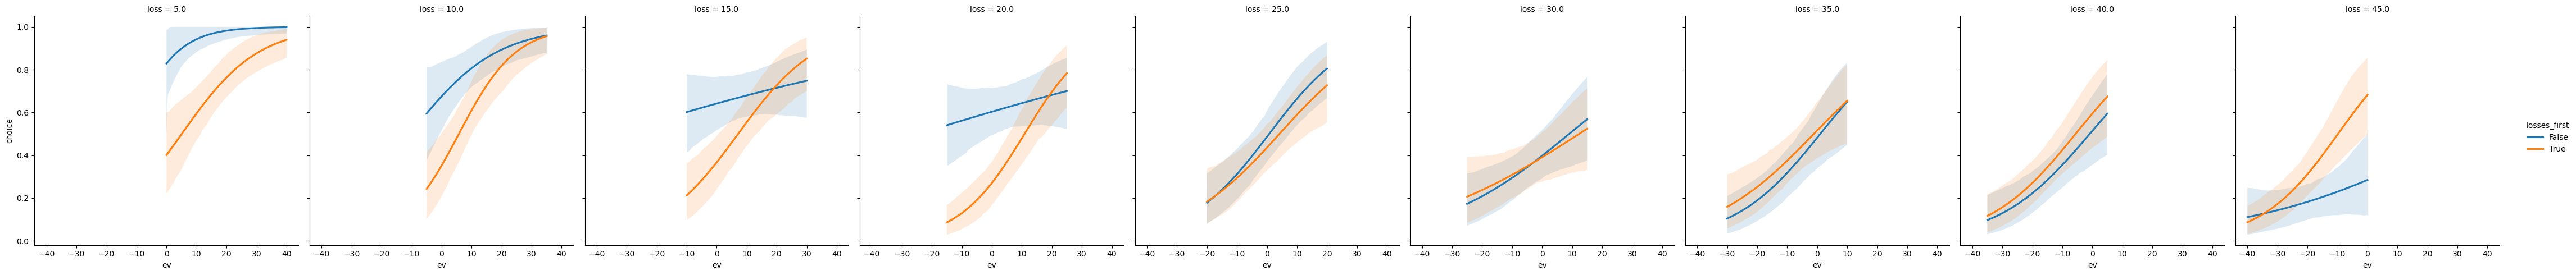

In [3]:
import seaborn as sns
sns.lmplot(x='ev', y='choice', data=data.reset_index(), col='loss', logistic=True, scatter=False, hue='losses_first')

Now we fit a `LossAversionRegressionModel`, that takes into account that `evidence_sd_gains` and `evidence_sd_losses` are different for
the two order.

In [4]:
model = LossAversionRegressionModel(regressors={'evidence_sd_gains':'losses_first', 'evidence_sd_losses':'losses_first'}, paradigm_type='mixed_vs_0', fix_prior_sds=False)


# We don't estimate hierarchical for now
model.build_estimation_model(data, hierarchical=False)

We now estimate a design matrix X for `evidence_sd_gains` and `evidence_sd_losses`. Note how one regressor
corresponds to the `evidence_sd_gains` when it is presented 2nd. The other regressor is the net effect on `evidence_sd_gains`
of losses being presented first 

<Axes: >

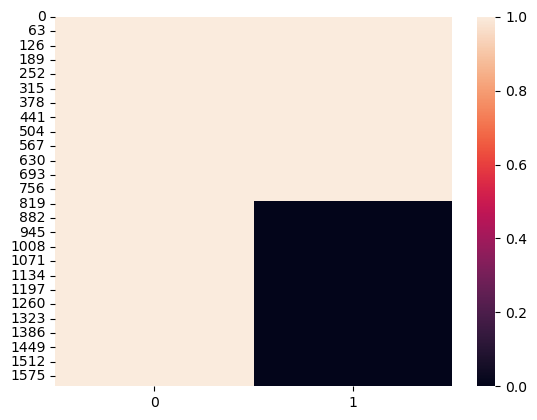

In [5]:
sns.heatmap(model.design_matrices['evidence_sd_gains'])

Let's sample from the posterior :)

In [6]:
idata = model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_mu_gains, prior_mu_losses, evidence_sd_gains, evidence_sd_losses, prior_sd_gains, prior_sd_losses]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


Look how every parameter has an extra level (in this case `evidence_sd_gains_regressors`) indicating which part of
the design matrix it corresponds to

In [7]:

idata.posterior['evidence_sd_gains'].to_dataframe().head()

evidence_sd_gains
chain draw evidence_sd_gains_regressors                   
0     0    Intercept                             -0.599968
           losses_first[T.True]                  -1.970541
      1    Intercept                              0.107046
           losses_first[T.True]                  -1.864040
      2    Intercept                              0.633783

Now we can calculate the raw values of the two parameter estimates.

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87620/2814239842.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['evidence_sd_gains'].to_dataframe().xs('Intercept', level='evidence_sd_gains_regressors'))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87620/2814239842.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.g

<Axes: ylabel='Density'>

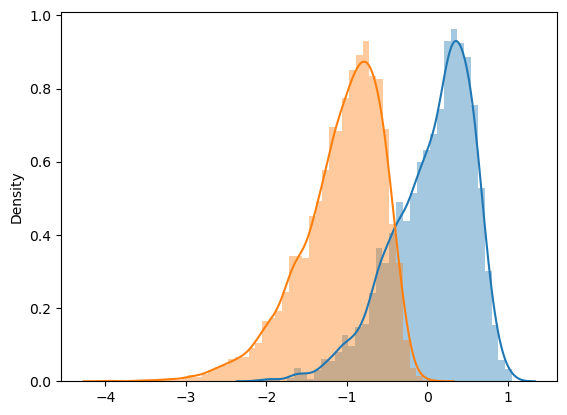

In [8]:
sns.distplot(idata.posterior['evidence_sd_gains'].to_dataframe().xs('Intercept', level='evidence_sd_gains_regressors'))
sns.distplot(idata.posterior['evidence_sd_gains'].to_dataframe().xs('losses_first[T.True]', level='evidence_sd_gains_regressors'))

Note that for the final calculation of `evidence_sd_gains` for a given trial using the GLM approach, the `softplus` transformation is still applied, to make sure
that `evidence_sd_gains` is always positive. We can do some data mangling to get the results we need.

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87620/3990449949.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(evidence_sd_gains_gains_first - evidence_sd_gains_losses_first)


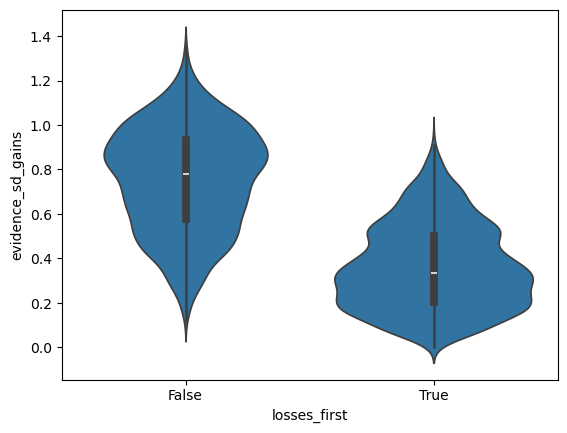

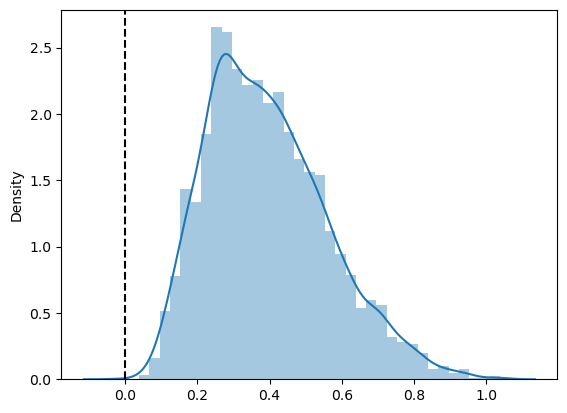

In [9]:
from  bauer.utils.math import softplus_np
import matplotlib.pyplot as plt

evidence_sd_gains_gains_first = softplus_np(idata.posterior['evidence_sd_gains'].to_dataframe().xs('Intercept', level='evidence_sd_gains_regressors'))
evidence_sd_gains_losses_first = softplus_np(idata.posterior['evidence_sd_gains'].to_dataframe().xs('Intercept', level='evidence_sd_gains_regressors') + idata.posterior['evidence_sd_gains'].to_dataframe().xs('losses_first[T.True]', level='evidence_sd_gains_regressors'))

evidence_sd_gains = pd.concat((evidence_sd_gains_gains_first, evidence_sd_gains_losses_first), keys=[False, True], names=['losses_first'])

sns.violinplot(x='losses_first', y='evidence_sd_gains', data=evidence_sd_gains.reset_index())

plt.figure()
sns.distplot(evidence_sd_gains_gains_first - evidence_sd_gains_losses_first)
plt.axvline(0.0, c='k',  ls='--')

We clearly found that if losses come first, the gains are represented with less noise...

and vice versa... 

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87620/1496962961.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(evidence_sd_losses_gains_first - evidence_sd_losses_losses_first)


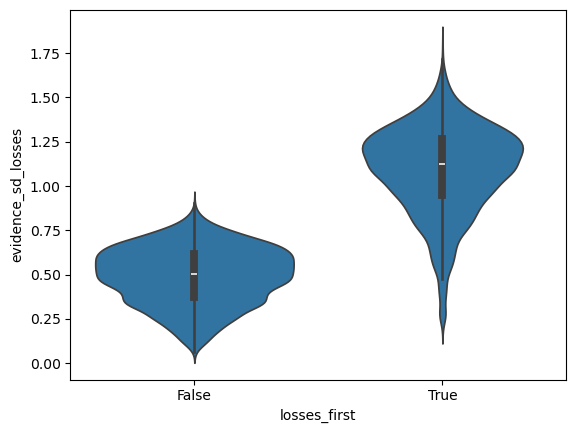

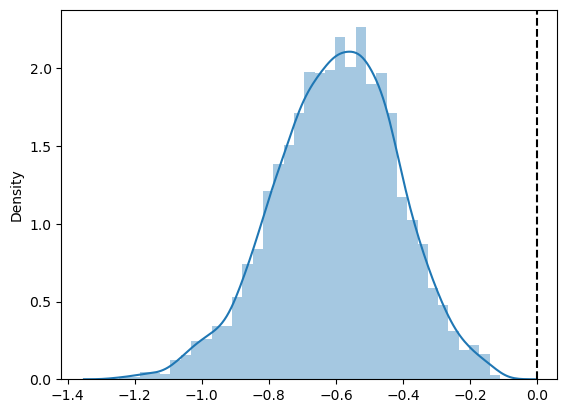

In [10]:
evidence_sd_losses_gains_first = softplus_np(idata.posterior['evidence_sd_losses'].to_dataframe().xs('Intercept', level='evidence_sd_losses_regressors'))
evidence_sd_losses_losses_first = softplus_np(idata.posterior['evidence_sd_losses'].to_dataframe().xs('Intercept', level='evidence_sd_losses_regressors') + idata.posterior['evidence_sd_losses'].to_dataframe().xs('losses_first[T.True]', level='evidence_sd_losses_regressors'))
evidence_sd_losses = pd.concat((evidence_sd_losses_gains_first, evidence_sd_losses_losses_first), keys=[False, True], names=['losses_first'])

sns.violinplot(x='losses_first', y='evidence_sd_losses', data=evidence_sd_losses.reset_index())

plt.figure()
sns.distplot(evidence_sd_losses_gains_first - evidence_sd_losses_losses_first)
plt.axvline(0.0, c='k', ls='--')

## Posterior predictive checks

In [11]:
ppc = model.ppc(data, idata)

Sampling: [ll_bernoulli]


In [12]:
from bauer.utils.bayes import summarize_ppc
from bauer.utils.plotting import plot_prediction

/Users/gdehol/git/bauer/bauer/utils/bayes.py:38: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


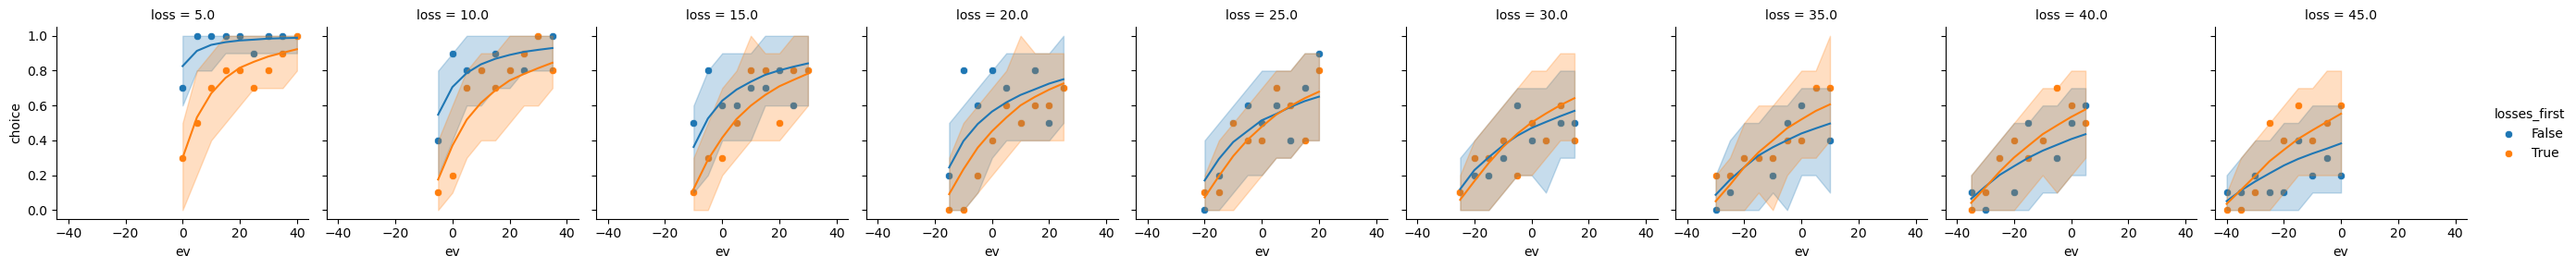

In [13]:
pred = summarize_ppc(ppc, groupby=['gain', 'loss', 'losses_first'])

pred = pred.join(data.groupby(['gain', 'loss', 'losses_first'])['choice'].mean())

pred = pred.assign(ev=lambda x: x.index.get_level_values('gain') - x.index.get_level_values('loss')).reset_index()

import seaborn as sns
g = sns.FacetGrid(pred, col='loss', hue='losses_first')
# g  = sns.relplot(x='ev', y='choice', data=pred, hue='losses_first', col='loss', kind='scatter')
g.map(sns.scatterplot, 'ev', 'choice')
g.map_dataframe(plot_prediction, x='ev')

g.add_legend()

# Simulating from a `RegressionModel`

Since `RegressionModel`s have for every parameter potentially multiple values (corresponding to the columns in the design matrix),
it's a bit more tricky to set up the parameters to simulate dat with. The easiest thing might be to use the function
`sample_parameters_from_prior` to get an example

In [14]:
pars = model.sample_parameters_from_prior(data)

pars

{('prior_mu_gains', 'Intercept'): -2.852120056299453,
 ('prior_mu_losses', 'Intercept'): 0.35863438341506926,
 ('evidence_sd_gains', 'Intercept'): 2.9644988809457193,
 ('evidence_sd_gains', 'losses_first[T.True]'): -0.7717956486115884,
 ('evidence_sd_losses', 'Intercept'): 0.41107444631125045,
 ('evidence_sd_losses', 'losses_first[T.True]'): 0.5584850555003128,
 ('prior_sd_gains', 'Intercept'): -0.6508907493541101,
 ('prior_sd_losses', 'Intercept'): 0.6988821280213575}

Note how `pars` is now a dictionary where every key is a `tuple`, with the first element the name of the parameter and the second element the corresponding
column in the corresponding design matrix.


**Also note that all these parameters live in the untransformed space. You can not nececesarily intepret them as you usually do**

In [15]:
data

losses_first  simulated_choice  gain  loss  choice   ev
trial sample                                                         
0     1               True              True   5.0   5.0    True  0.0
      2               True             False   5.0   5.0   False  0.0
      3               True             False   5.0   5.0   False  0.0
      4               True             False   5.0   5.0   False  0.0
      5               True             False   5.0   5.0   False  0.0
...                    ...               ...   ...   ...     ...  ...
80    6              False              True  45.0  45.0    True  0.0
      7              False             False  45.0  45.0   False  0.0
      8              False             False  45.0  45.0   False  0.0
      9              False             False  45.0  45.0   False  0.0
      10             False             False  45.0  45.0   False  0.0

[1620 rows x 6 columns]

In [16]:
pars

{('prior_mu_gains', 'Intercept'): -2.852120056299453,
 ('prior_mu_losses', 'Intercept'): 0.35863438341506926,
 ('evidence_sd_gains', 'Intercept'): 2.9644988809457193,
 ('evidence_sd_gains', 'losses_first[T.True]'): -0.7717956486115884,
 ('evidence_sd_losses', 'Intercept'): 0.41107444631125045,
 ('evidence_sd_losses', 'losses_first[T.True]'): 0.5584850555003128,
 ('prior_sd_gains', 'Intercept'): -0.6508907493541101,
 ('prior_sd_losses', 'Intercept'): 0.6988821280213575}

In [17]:
# Now let's use some more meanignful parmeter values
# Note that we need to define them in the untransformed space! 
# That's where `Model.backward_transform` comes in handy!

pars = {('prior_mu_gains', 'Intercept'): model.backward_transform(np.log(25), 'prior_mu_gains'),
        ('prior_mu_losses', 'Intercept'): model.backward_transform(np.log(25), 'prior_mu_losses'),
        ('prior_sd_gains', 'Intercept'): model.backward_transform(1.0, 'prior_sd_gains'),
        ('prior_sd_losses', 'Intercept'): model.backward_transform(1.0, 'prior_sd_losses'),
        ('evidence_sd_gains', 'Intercept'): model.backward_transform(1.0, 'evidence_sd_gains'),
        ('evidence_sd_losses', 'Intercept'): model.backward_transform(0.3, 'evidence_sd_losses'),
        ('evidence_sd_gains', 'losses_first[T.True]'): model.backward_transform(0.5, 'evidence_sd_gains') - model.backward_transform(1.0, 'evidence_sd_gains'),
        ('evidence_sd_losses', 'losses_first[T.True]'): model.backward_transform(0.75, 'evidence_sd_losses') - model.backward_transform(0.3, 'evidence_sd_losses')
        }
# Set up paradigm (note: now we also have a subjet level for each trial)
gains = np.arange(5., 50., 1)
losses = np.arange(5., 50., 1)
losses_first = [True, False]


paradigm = pd.MultiIndex.from_product([gains, losses, losses_first], names=['gain', 'loss', 'losses_first']).to_frame(index=False)

In [18]:
data = model.simulate(paradigm, pars, n_samples=50)
data['choice'] = data['simulated_choice']
data['ev'] = data['gain'] - data['loss']


<Axes: xlabel='loss', ylabel='gain'>

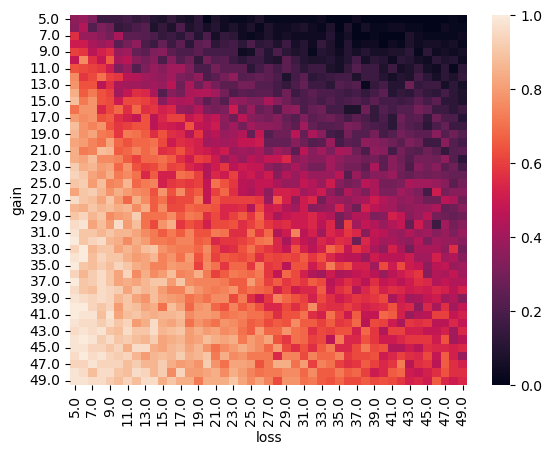

In [19]:
choices = data.pivot_table(index=['losses_first', 'gain'], columns='loss', values='choice',aggfunc='mean')

sns.heatmap(choices.loc[True])

<Axes: xlabel='loss', ylabel='gain'>

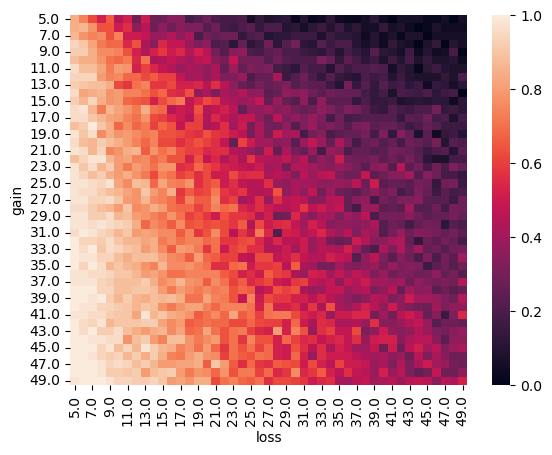

In [20]:
sns.heatmap(choices.loc[False])